# 傾向スコアマッチング
因果推論の手法の一つで、「似たような条件のデータ同士」をペアにすることで、2つのグループをできるだけ公平に比べることができる。

https://chatgpt.com/c/67b3308d-0fb0-8006-b8e2-3afab3f797f7

https://chatgpt.com/c/67b339fe-cebc-8006-aeed-f2615ac19cc3

### ロジスティック回帰×1対1マッチング×t検定

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance
from statsmodels.stats.weightstats import ttest_ind

In [7]:
# データ読み込み
df = pd.read_csv("../data/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [8]:
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,10600.54830
1334,18,0,31.920,0,0,northeast,2205.98080
1335,18,0,36.850,0,0,southeast,1629.83350
1336,21,0,25.800,0,0,southwest,2007.94500


- age: 年齢
- sex: 性別
- bmi: BMI
- children: 子どもの数
- smoker: 喫煙者かどうか
- region: 居住地域
- charges: 医療費

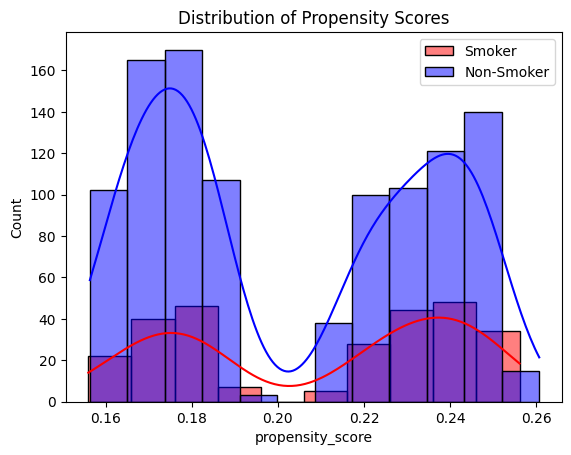

In [9]:
# 説明変数（共変量）を選択（性別, 年齢, BMI, 子供の数）
X = df[['age', 'sex', 'bmi', 'children']]
y = df['smoker']

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ロジスティック回帰で傾向スコア推定
logit = LogisticRegression()
logit.fit(X_scaled, y)

# 傾向スコアの取得
df['propensity_score'] = logit.predict_proba(X_scaled)[:, 1]

# 傾向スコアの分布を確認
sns.histplot(df[df['smoker'] == 1]['propensity_score'], color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(df[df['smoker'] == 0]['propensity_score'], color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Propensity Scores")
plt.show()

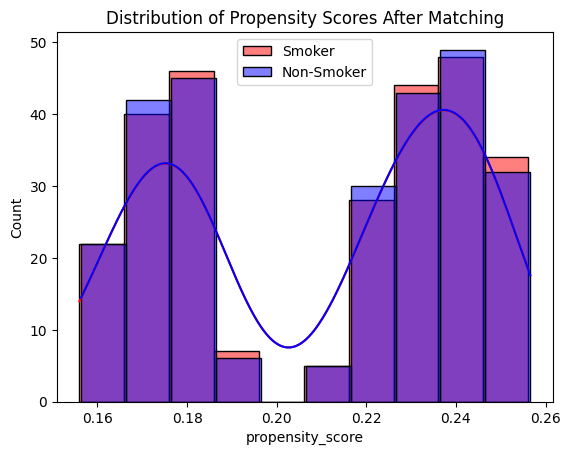

In [10]:
from scipy.spatial import distance

# 傾向スコアを float 型に変換
df['propensity_score'] = df['propensity_score'].astype(float)

# 処置群と対照群のデータ
treated = df[df['smoker'] == 1].copy()
control = df[df['smoker'] == 0].copy()

# 最近傍マッチング
matched_indices = []
for i, row in treated.iterrows():
    # 適切な形式に変換
    treated_score = np.array([[row['propensity_score']]])  # 2D array にする
    control_scores = control[['propensity_score']].to_numpy()  # 2D array にする
    
    # 最近傍マッチングのインデックスを取得
    min_idx = distance.cdist(treated_score, control_scores).argmin()
    
    # インデックスをリストに追加
    matched_indices.append(control.index[min_idx])

# マッチング後のデータ
matched_control = df.loc[matched_indices].copy()
matched_treated = treated.copy()

# マッチング後のデータセット作成
matched_df = pd.concat([matched_treated, matched_control])

# マッチング後の傾向スコア分布確認
sns.histplot(matched_df[matched_df['smoker'] == 1]['propensity_score'], color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(matched_df[matched_df['smoker'] == 0]['propensity_score'], color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Propensity Scores After Matching")
plt.show()

In [11]:
# マッチング前後の共変量の平均比較
before_matching = df.groupby('smoker')[['age', 'bmi', 'children']].mean()
after_matching = matched_df.groupby('smoker')[['age', 'bmi', 'children']].mean()

balance_check = pd.concat([before_matching, after_matching], keys=['Before Matching', 'After Matching'])

from IPython.display import display

display(balance_check)

age        bmi  children
                smoker                                
Before Matching 0       39.385338  30.651795  1.090226
                1       38.514599  30.708449  1.113139
After Matching  0       38.427007  31.506533  1.029197
                1       38.514599  30.708449  1.113139

In [12]:
# 医療費の平均比較
treated_charges = matched_df[matched_df['smoker'] == 1]['charges']
control_charges = matched_df[matched_df['smoker'] == 0]['charges']

# t検定
t_stat, p_value, _ = ttest_ind(treated_charges, control_charges)

print(f"処置群（喫煙者）の医療費平均: {treated_charges.mean():.2f}")
print(f"対照群（非喫煙者）の医療費平均: {control_charges.mean():.2f}")
print(f"t値: {t_stat:.2f}, p値: {p_value:.4f}")

処置群（喫煙者）の医療費平均: 32050.23
対照群（非喫煙者）の医療費平均: 7670.83
t値: 31.79, p値: 0.0000


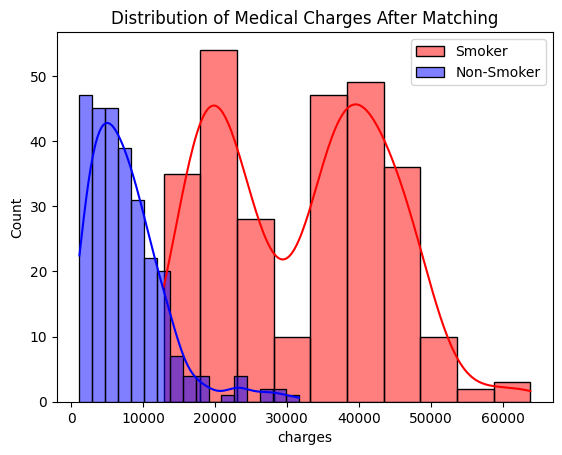

In [17]:
sns.histplot(treated_charges, color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(control_charges, color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Medical Charges After Matching")
plt.show()

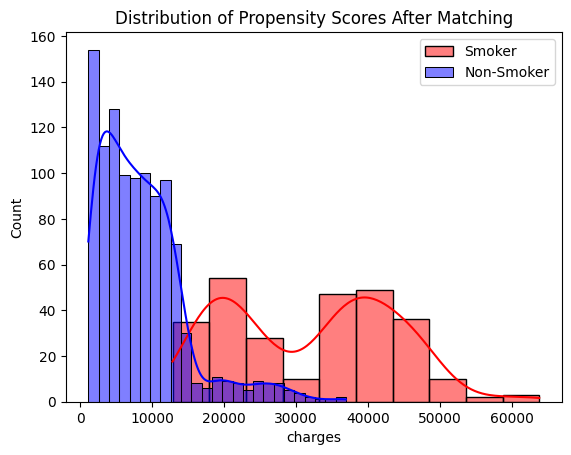

In [14]:
sns.histplot(df[df['smoker'] == 1]['charges'], color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(df[df['smoker'] == 0]['charges'], color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Propensity Scores After Matching")
plt.show()

In [15]:
df['smoker'].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [16]:
print(len(treated_charges), len(control_charges))

274 274


### ロジスティック回帰×1対Nマッチング×t検定

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance
from statsmodels.stats.weightstats import ttest_ind

In [19]:
# データ読み込み
df = pd.read_csv("../data/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [20]:
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,10600.54830
1334,18,0,31.920,0,0,northeast,2205.98080
1335,18,0,36.850,0,0,southeast,1629.83350
1336,21,0,25.800,0,0,southwest,2007.94500


- age: 年齢
- sex: 性別
- bmi: BMI
- children: 子どもの数
- smoker: 喫煙者かどうか
- region: 居住地域
- charges: 医療費

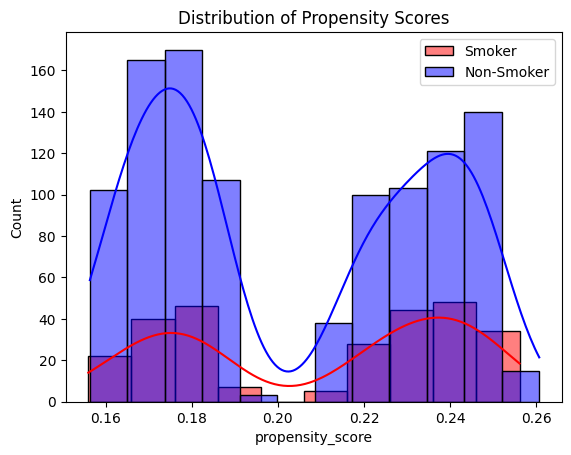

In [21]:
# 説明変数（共変量）を選択（性別, 年齢, BMI, 子供の数）
X = df[['age', 'sex', 'bmi', 'children']]
y = df['smoker']

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ロジスティック回帰で傾向スコア推定
logit = LogisticRegression()
logit.fit(X_scaled, y)

# 傾向スコアの取得
df['propensity_score'] = logit.predict_proba(X_scaled)[:, 1]

# 傾向スコアの分布を確認
sns.histplot(df[df['smoker'] == 1]['propensity_score'], color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(df[df['smoker'] == 0]['propensity_score'], color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Propensity Scores")
plt.show()

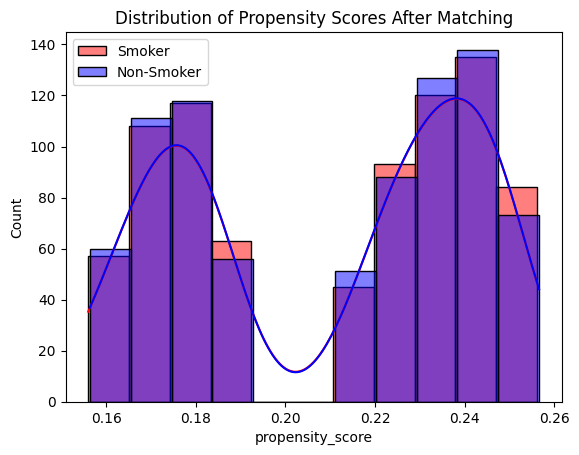

In [23]:
from scipy.spatial import distance

N = 3

# 傾向スコアを float 型に変換
df['propensity_score'] = df['propensity_score'].astype(float)

# 処置群と対照群のデータ
treated = df[df['smoker'] == 1].copy()
control = df[df['smoker'] == 0].copy()

# 最近傍マッチング（1対N）
matched_control_indices = []  # マッチした対照群のインデックス
matched_treated_indices = []  # 対応する処置群のインデックス

# 最近傍マッチング
matched_indices = []
for i, row in treated.iterrows():
    # 適切な形式に変換
    treated_score = np.array([[row['propensity_score']]])  # 2D array にする
    control_scores = control[['propensity_score']].to_numpy()  # 2D array にする

    distances = distance.cdist(treated_score, control_scores).flatten()
    nearest_indices = distances.argsort()[:N]
    
    matched_control_indices.extend(control.index[nearest_indices])
    matched_treated_indices.extend([i] * N)
    
# マッチング後のデータ
matched_treated = treated.loc[matched_treated_indices].reset_index(drop=True)
matched_control = control.loc[matched_control_indices].reset_index(drop=True)

# マッチング後のデータセット作成
matched_df = pd.concat([matched_treated, matched_control]).reset_index(drop=True)

# マッチング後の傾向スコア分布確認
sns.histplot(matched_df[matched_df['smoker'] == 1]['propensity_score'], color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(matched_df[matched_df['smoker'] == 0]['propensity_score'], color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Propensity Scores After Matching")
plt.show()

In [24]:
# マッチング前後の共変量の平均比較
before_matching = df.groupby('smoker')[['age', 'bmi', 'children']].mean()
after_matching = matched_df.groupby('smoker')[['age', 'bmi', 'children']].mean()

balance_check = pd.concat([before_matching, after_matching], keys=['Before Matching', 'After Matching'])

from IPython.display import display

display(balance_check)

age        bmi  children
                smoker                                
Before Matching 0       39.385338  30.651795  1.090226
                1       38.514599  30.708449  1.113139
After Matching  0       38.391727  30.734337  1.077859
                1       38.514599  30.708449  1.113139

In [25]:
# 医療費の平均比較
treated_charges = matched_df[matched_df['smoker'] == 1]['charges']
control_charges = matched_df[matched_df['smoker'] == 0]['charges']

# t検定
t_stat, p_value, _ = ttest_ind(treated_charges, control_charges)

print(f"処置群（喫煙者）の医療費平均: {treated_charges.mean():.2f}")
print(f"対照群（非喫煙者）の医療費平均: {control_charges.mean():.2f}")
print(f"t値: {t_stat:.2f}, p値: {p_value:.4f}")

処置群（喫煙者）の医療費平均: 32050.23
対照群（非喫煙者）の医療費平均: 7863.58
t値: 54.05, p値: 0.0000


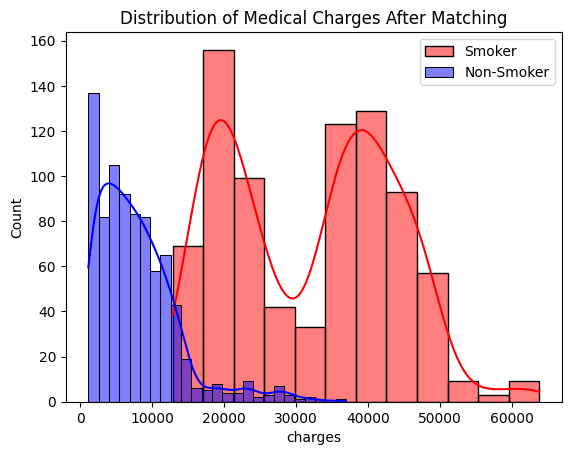

In [26]:
sns.histplot(treated_charges, color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(control_charges, color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Medical Charges After Matching")
plt.show()

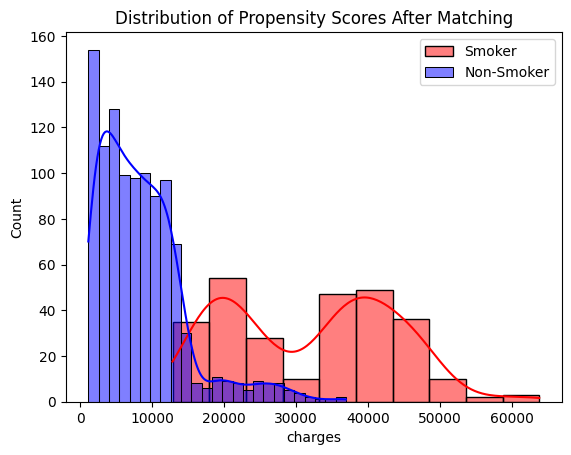

In [27]:
sns.histplot(df[df['smoker'] == 1]['charges'], color='red', alpha=0.5, label='Smoker', kde=True)
sns.histplot(df[df['smoker'] == 0]['charges'], color='blue', alpha=0.5, label='Non-Smoker', kde=True)
plt.legend()
plt.title("Distribution of Propensity Scores After Matching")
plt.show()

In [28]:
df['smoker'].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [29]:
print(len(treated_charges), len(control_charges))

822 822
